In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng
import astropy.cosmology

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import random_utils

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

# Visualize samples

In [3]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

G_max = 20
fn_gaia = f'../data/gaia_G{G_max}.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [40]:
n_jack = 12
locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_jack)
cmap = matplotlib.cm.get_cmap('turbo')

In [55]:
def plot_lb(tab, tab_dummy, jack=None):
    if jack is not None:
        color = cmap(locs_norm(jack))
    plt.figure(figsize=(6,4))
    plt.title(f'Jackknife sample {jack}')
    plt.scatter(tab['l'], tab['b'], alpha=0.02, s=0.1, color=color)
    plt.xlim(0.0, 360.0)
    plt.xlabel('l')
    plt.ylabel('b')
    return np.mean(tab['l'])

Jackknife mean & var with n=12


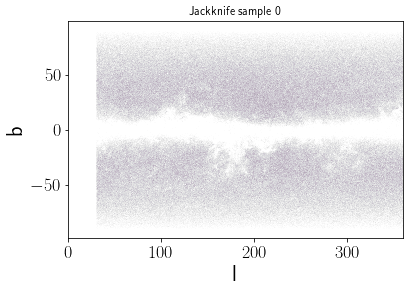

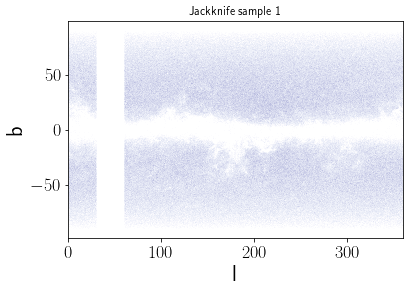

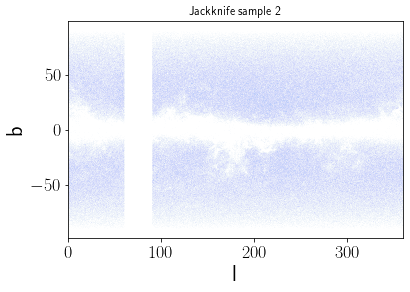

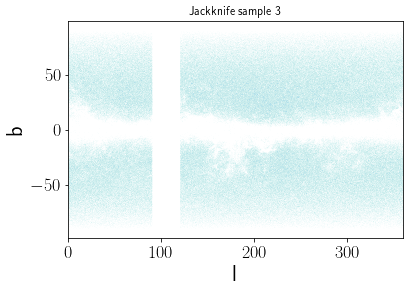

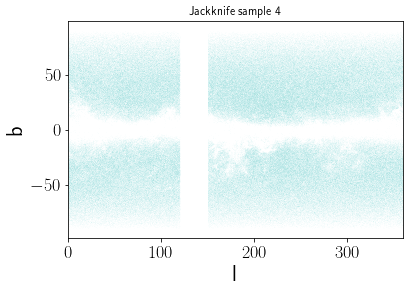

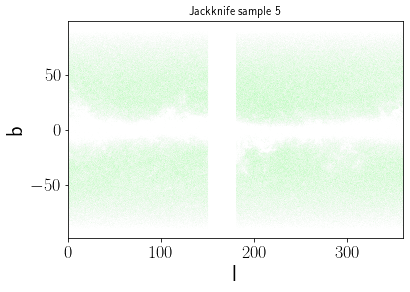

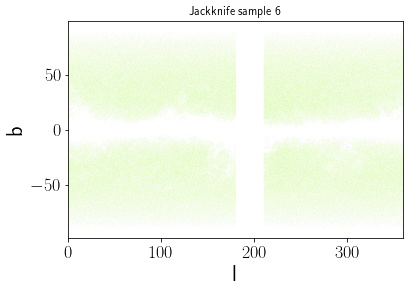

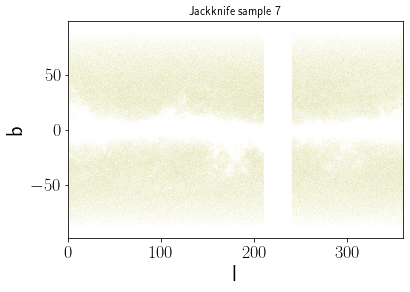

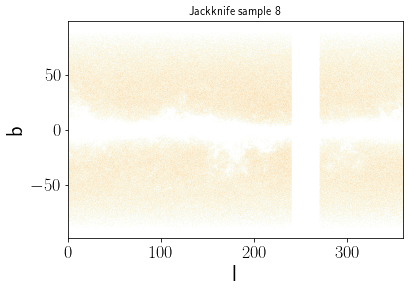

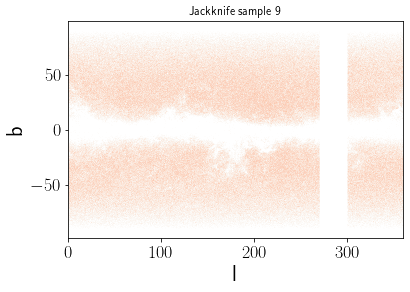

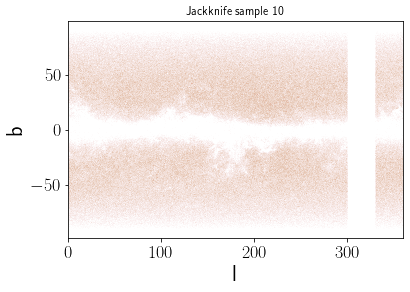

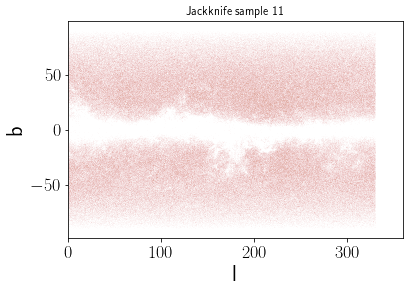

In [56]:
m, v = utils.jackknife(plot_lb, tab_gaia, tab_gaia) #second tab_gaia is dummpy

# Jackknife samples

In [57]:
G_max = 20
bin_size = 4
n_jack = 12
r_edges_arr = []
xi_arr = []
for jack in range(n_jack):
    fn_xi_jack = f'../data/xis/xi_G{G_max}_bw{bin_size}_jack{jack:02d}.npy'
    r_edges, xi = np.load(fn_xi_jack, allow_pickle=True)
    r_edges_arr.append( r_edges )
    xi_arr.append( xi )
xi_arr = np.array(xi_arr)
print(xi_arr.shape)

(12, 32)


In [58]:
xi_mean, var_xi = utils.jackknife_mean_var(xi_arr)

Jackknife mean & var with n=12


In [59]:
fn_xi = f'../data/xis/xi_G{G_max}_bw{bin_size}.npy'
r_edges_all, xi_all = np.load(fn_xi, allow_pickle=True)

In [60]:
def edges_to_avg_linear(r_edges):
    return 0.5 * (r_edges[1:] + r_edges[:-1])

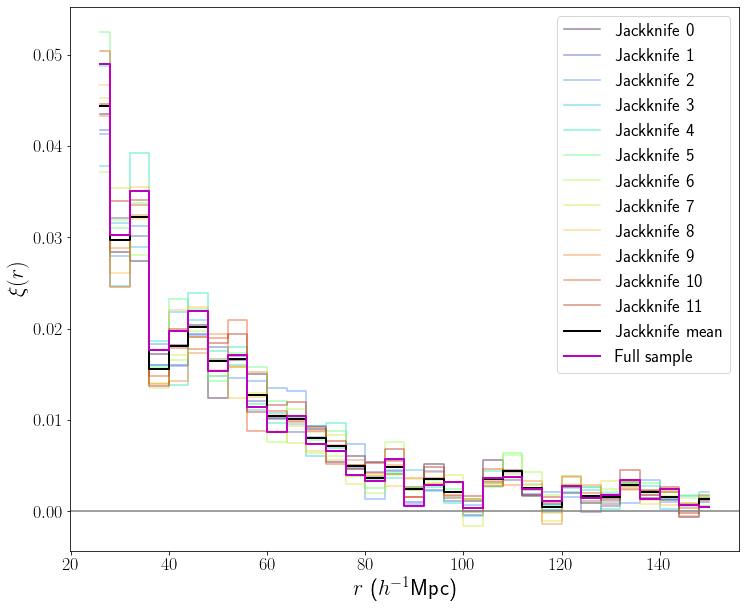

In [63]:
plt.figure(figsize=(12,10))

# assume all r_edges are same for jacks
r_avg = edges_to_avg_linear(r_edges_arr[0])
r_avg_all = edges_to_avg_linear(r_edges_all)

for jack in range(n_jack):
    plt.step(r_avg, xi_arr[jack], where='mid', color=cmap(locs_norm(jack)), alpha=0.5, label=f'Jackknife {jack}')
plt.step(r_avg, xi_mean, where='mid', color='k', lw=2, alpha=1, label='Jackknife mean')
plt.step(r_avg_all, xi_all, where='mid', color='m', lw=2, alpha=1, label='Full sample')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


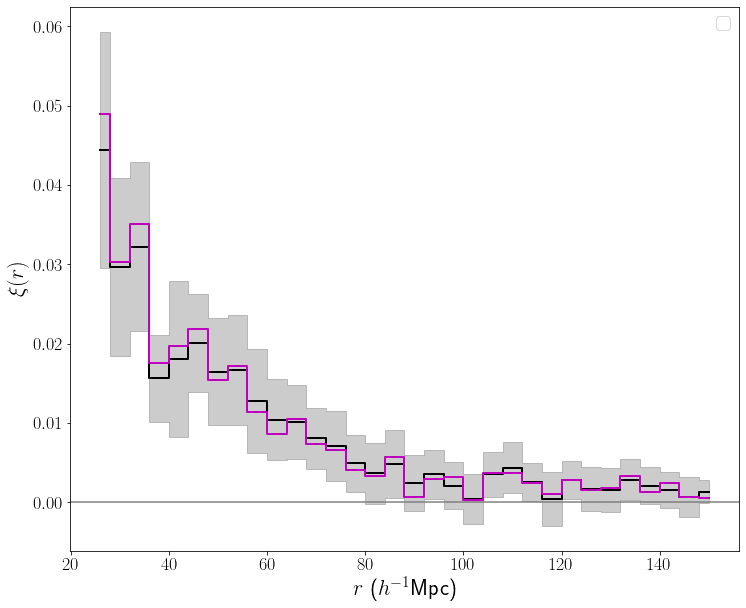

In [62]:
plt.figure(figsize=(12,10))

# assume all r_edges are same for jacks
r_avg = edges_to_avg_linear(r_edges_arr[0])
plt.fill_between(r_avg, xi_mean-np.sqrt(var_xi), xi_mean+np.sqrt(var_xi), step='mid', color='k', alpha=0.2)
  
plt.step(r_avg, xi_mean, where='mid', color='k', lw=2, alpha=1)

r_avg_all = edges_to_avg_linear(r_edges_all)
plt.step(r_avg_all, xi_all, where='mid', color='m', lw=2, alpha=1)

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()